In [1]:
!pip install -q nltk

In [2]:
import nltk

nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import joblib as jb

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv("/content/data.csv")
df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


# EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


# Relative to the above df.info():
* The data contains around 8518 observations or instances and total of 8 features.
* There is only one feature or column with no missing data and that's Ratings feature.
* column with most missing values is the month.

In [7]:
(df.isnull().sum() / df.shape[0]) * 100

Reviewer Name      0.117398
Review Title       0.117398
Place of Review    0.586992
Up Votes           0.117398
Down Votes         0.117398
Month              5.459028
Review text        0.093919
Ratings            0.000000
dtype: float64

## Filling missing categorical values.

In [8]:
# df["Reviewer Name"].fillna(df["Reviewer Name"].mode()[0], inplace = True)
# df["Review Title"].fillna(df["Review Title"].mode()[0], inplace = True)
# df["Place of Review"].fillna(df["Place of Review"].mode()[0], inplace = True)
# df["Review text"].fillna("Not Available", inplace = True)

## Filling missing numerical values.

In [9]:
# df["Up Votes"].fillna(df["Up Votes"].median(), inplace = True)
# df["Down Votes"].fillna(df["Down Votes"].median(), inplace = True)

## Filling Time series data.

In [10]:
# df["Month"].fillna(method = "ffill", inplace = True)

In [11]:
df.dropna(axis = 0, inplace = True)

In [12]:
(df.isnull().sum() / df.shape[0]) * 100

Reviewer Name      0.0
Review Title       0.0
Place of Review    0.0
Up Votes           0.0
Down Votes         0.0
Month              0.0
Review text        0.0
Ratings            0.0
dtype: float64

## Dealing with the Ratings.
* Ratings range 1-5.
* So to categorize them into two: positive or negative. Then we should remove those that can indicate neutrality. like 3.

In [13]:
df["Ratings"].unique()

array([4, 1, 5, 2, 3])

In [14]:
used_ratings = {
    1:"Negative",
    2:"Negative",
    4:"Positive",
    5:"Positive"
}
df = df[df["Ratings"] != 3]
df["Label"] = df[df["Ratings"] != 3]["Ratings"].map(used_ratings)

In [15]:
df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings,Label
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4,Positive
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1,Negative
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1,Negative
5,Baji Sankar,Mind-blowing purchase,"Certified Buyer, Hyderabad",173.0,45.0,Oct 2018,Good quality product. Delivered on time.READ MORE,5,Positive
6,Flipkart Customer,Must buy!,"Certified Buyer, Doom Dooma",403.0,121.0,Jan 2020,BEST PURCHASE It is a good quality and is more...,5,Positive


In [16]:
df = df[["Review text", "Label"]]

In [17]:
df

,Review text,Label
0,"Nice product, good quality, but price is now r...",Positive
1,They didn't supplied Yonex Mavis 350. Outside ...,Negative
2,Worst product. Damaged shuttlecocks packed in ...,Negative
5,Good quality product. Delivered on time.READ MORE,Positive
6,BEST PURCHASE It is a good quality and is more...,Positive
...,...,...
8495,Thanks to the delivery boy ... Service is alwa...,Positive
8496,Over priced even after 50% discount price is m...,Negative
8497,Too much priced. It was getting me for Rs. 640...,Negative
8499,Hii flipkart customers care..why your delivery...,Positive


## As we can see the below command:
* Each **Review text** has some extention or like some text in it which reads as **READ MORE**
* i.e: Good quality product. Delivered on time.READ MORE
* So, better to remove the text from our text.


In [18]:
df["Review text"][5]

'Good quality product. Delivered on time.READ MORE'

In [19]:
df["Review text"] = df[df["Review text"].str.contains("READ MORE")]["Review text"].str.replace("READ MORE", "")

In [20]:
df["Review text"][5]

'Good quality product. Delivered on time.'

# Visualization on the target features.

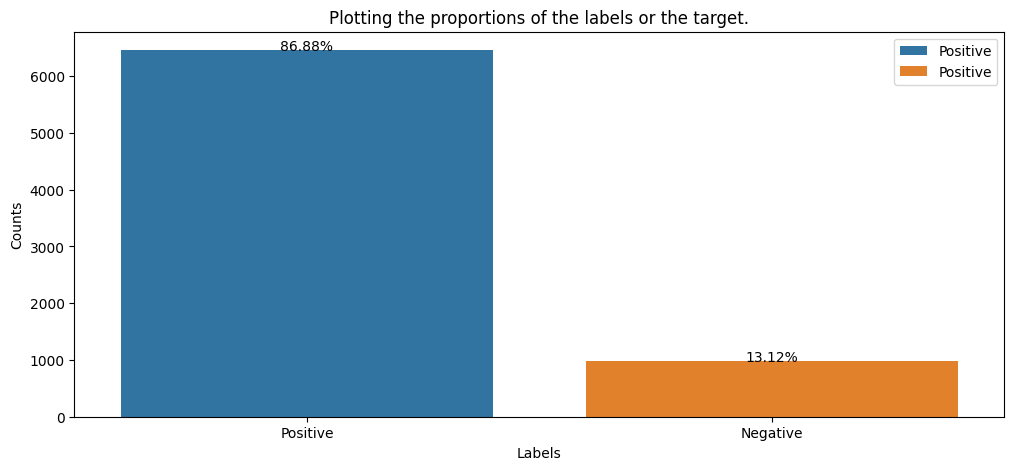

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 5))
total = len(df)  # Total number of samples

# Create the countplot
sns.countplot(data=df, x="Label", hue = "Label", label="Positive")

# Add percentages to each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.5, f'{height / total:.2%}', ha="center")

plt.xlabel("Labels")
plt.ylabel("Counts")
plt.title("Plotting the proportions of the labels or the target.")
plt.legend()
plt.show()

# Creating the WordCloud

In [22]:
from wordcloud import WordCloud

In [23]:
word_list = ['Amazing', 'Terrific', 'Phenomenal', 'Perfect', 'Awesome', 'Superb', 'Best', 'Excellent', 'Like', 'Outstanding', 'Love', 'Top-notch', 'Splendid', 'Impressive', 'Remarkable', 'Wonderful', 'Great', 'Fabulous', 'Exceptional', 'Fantastic']

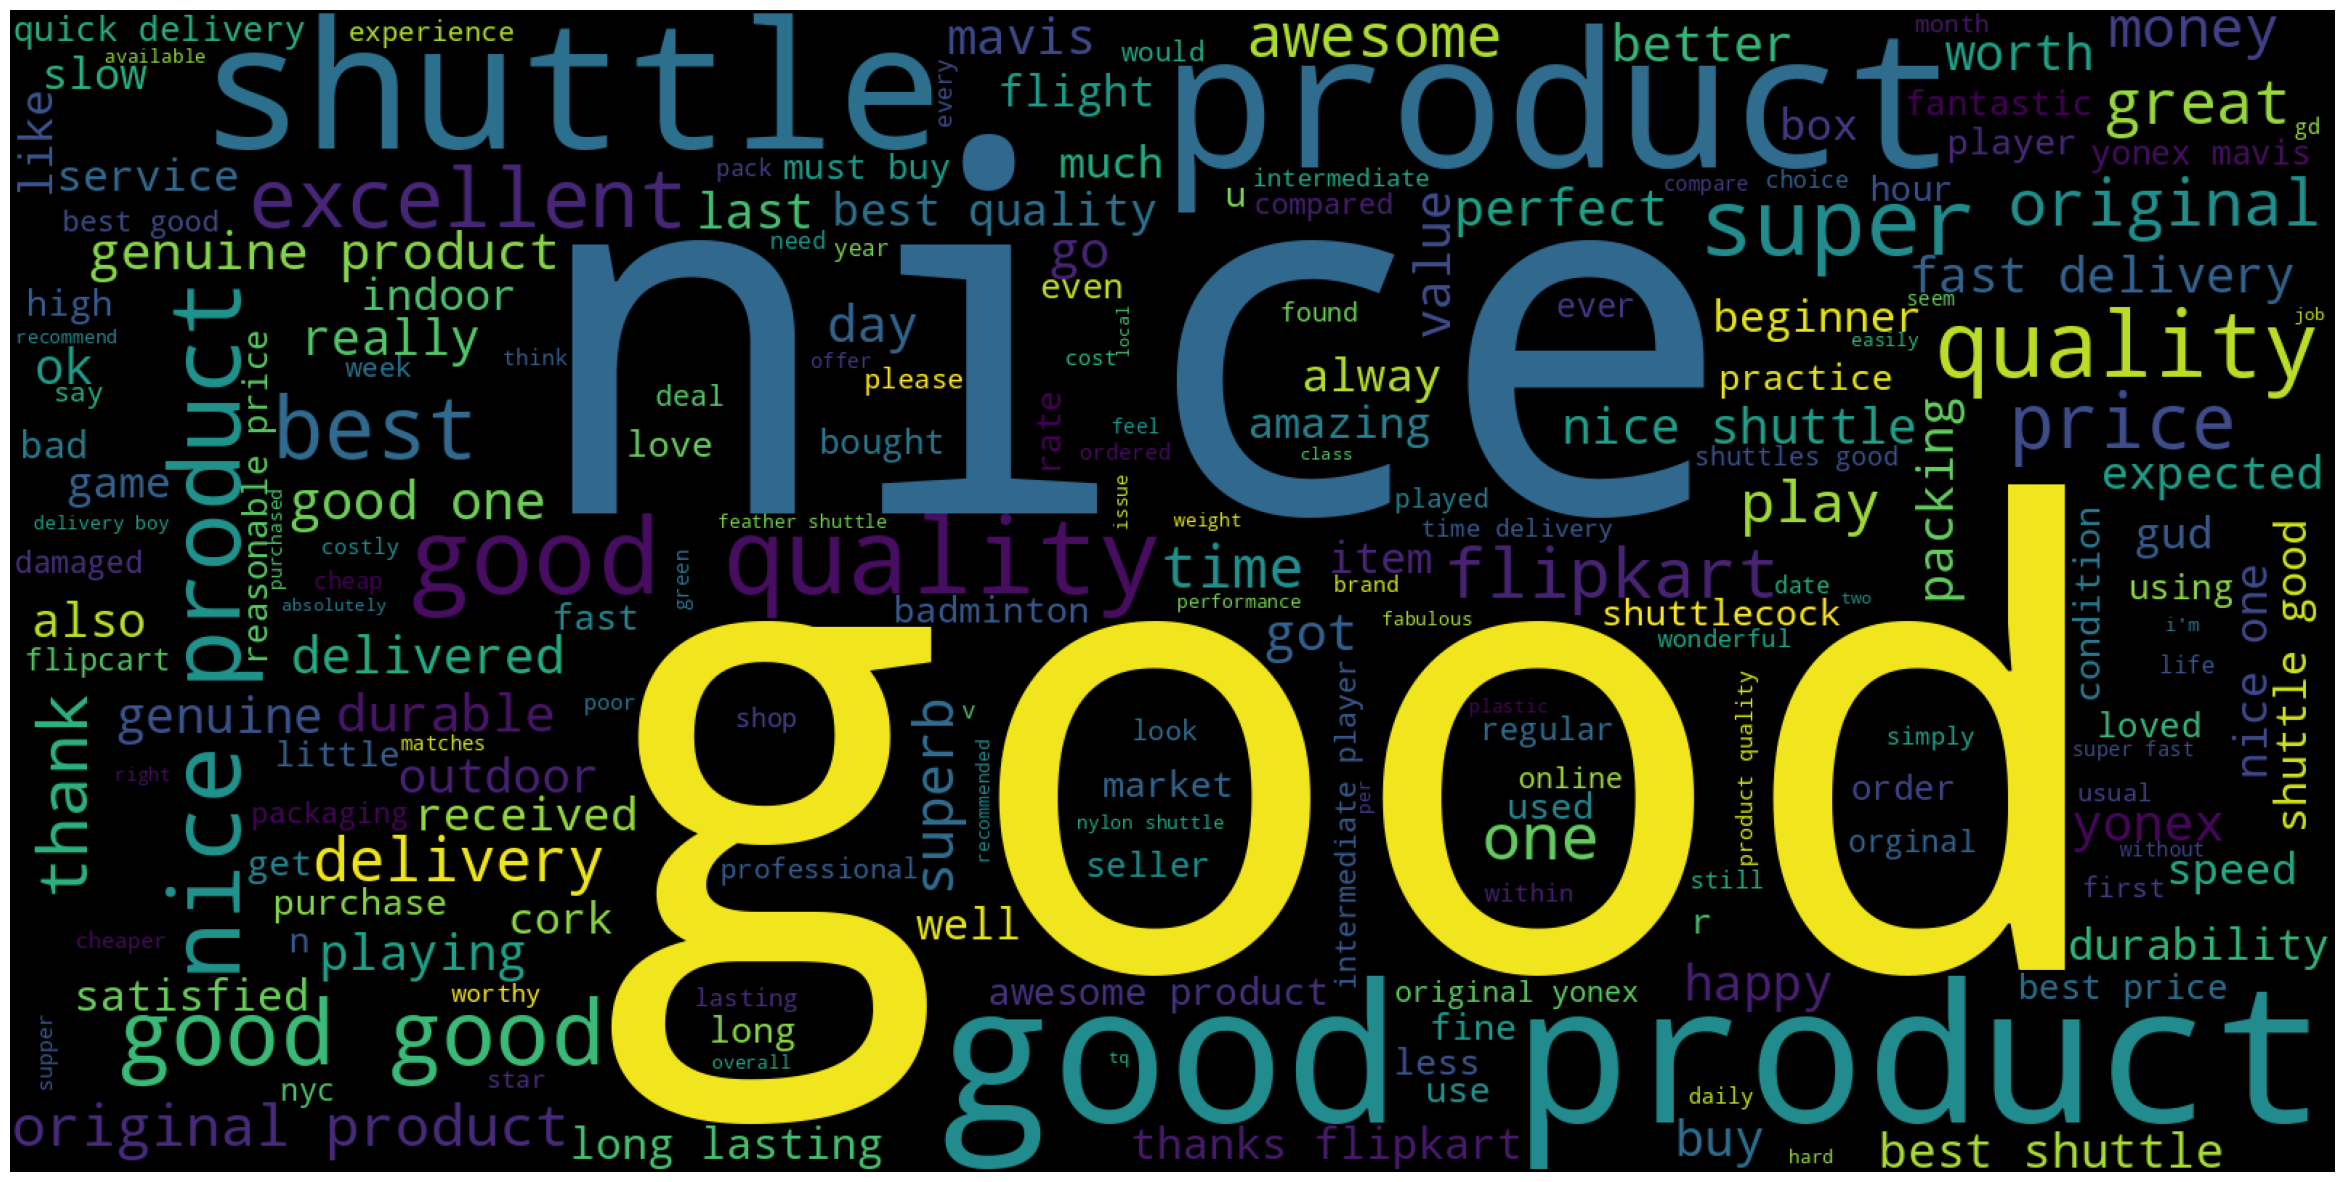

In [24]:
df_positive = df[df["Label"] == "Positive"]

words = " ".join(df_positive["Review text"]).lower()

clean_words = " ".join([word for word in words.split() if word not in word_list])

positive_wordcloud = WordCloud(stopwords=stopwords.words("english"),
                      background_color='black',
                      width=1600,
                      height=800
                     ).generate(clean_words)
plt.figure(1,figsize=(30,20))
plt.imshow(positive_wordcloud)
plt.axis('off')
plt.show()

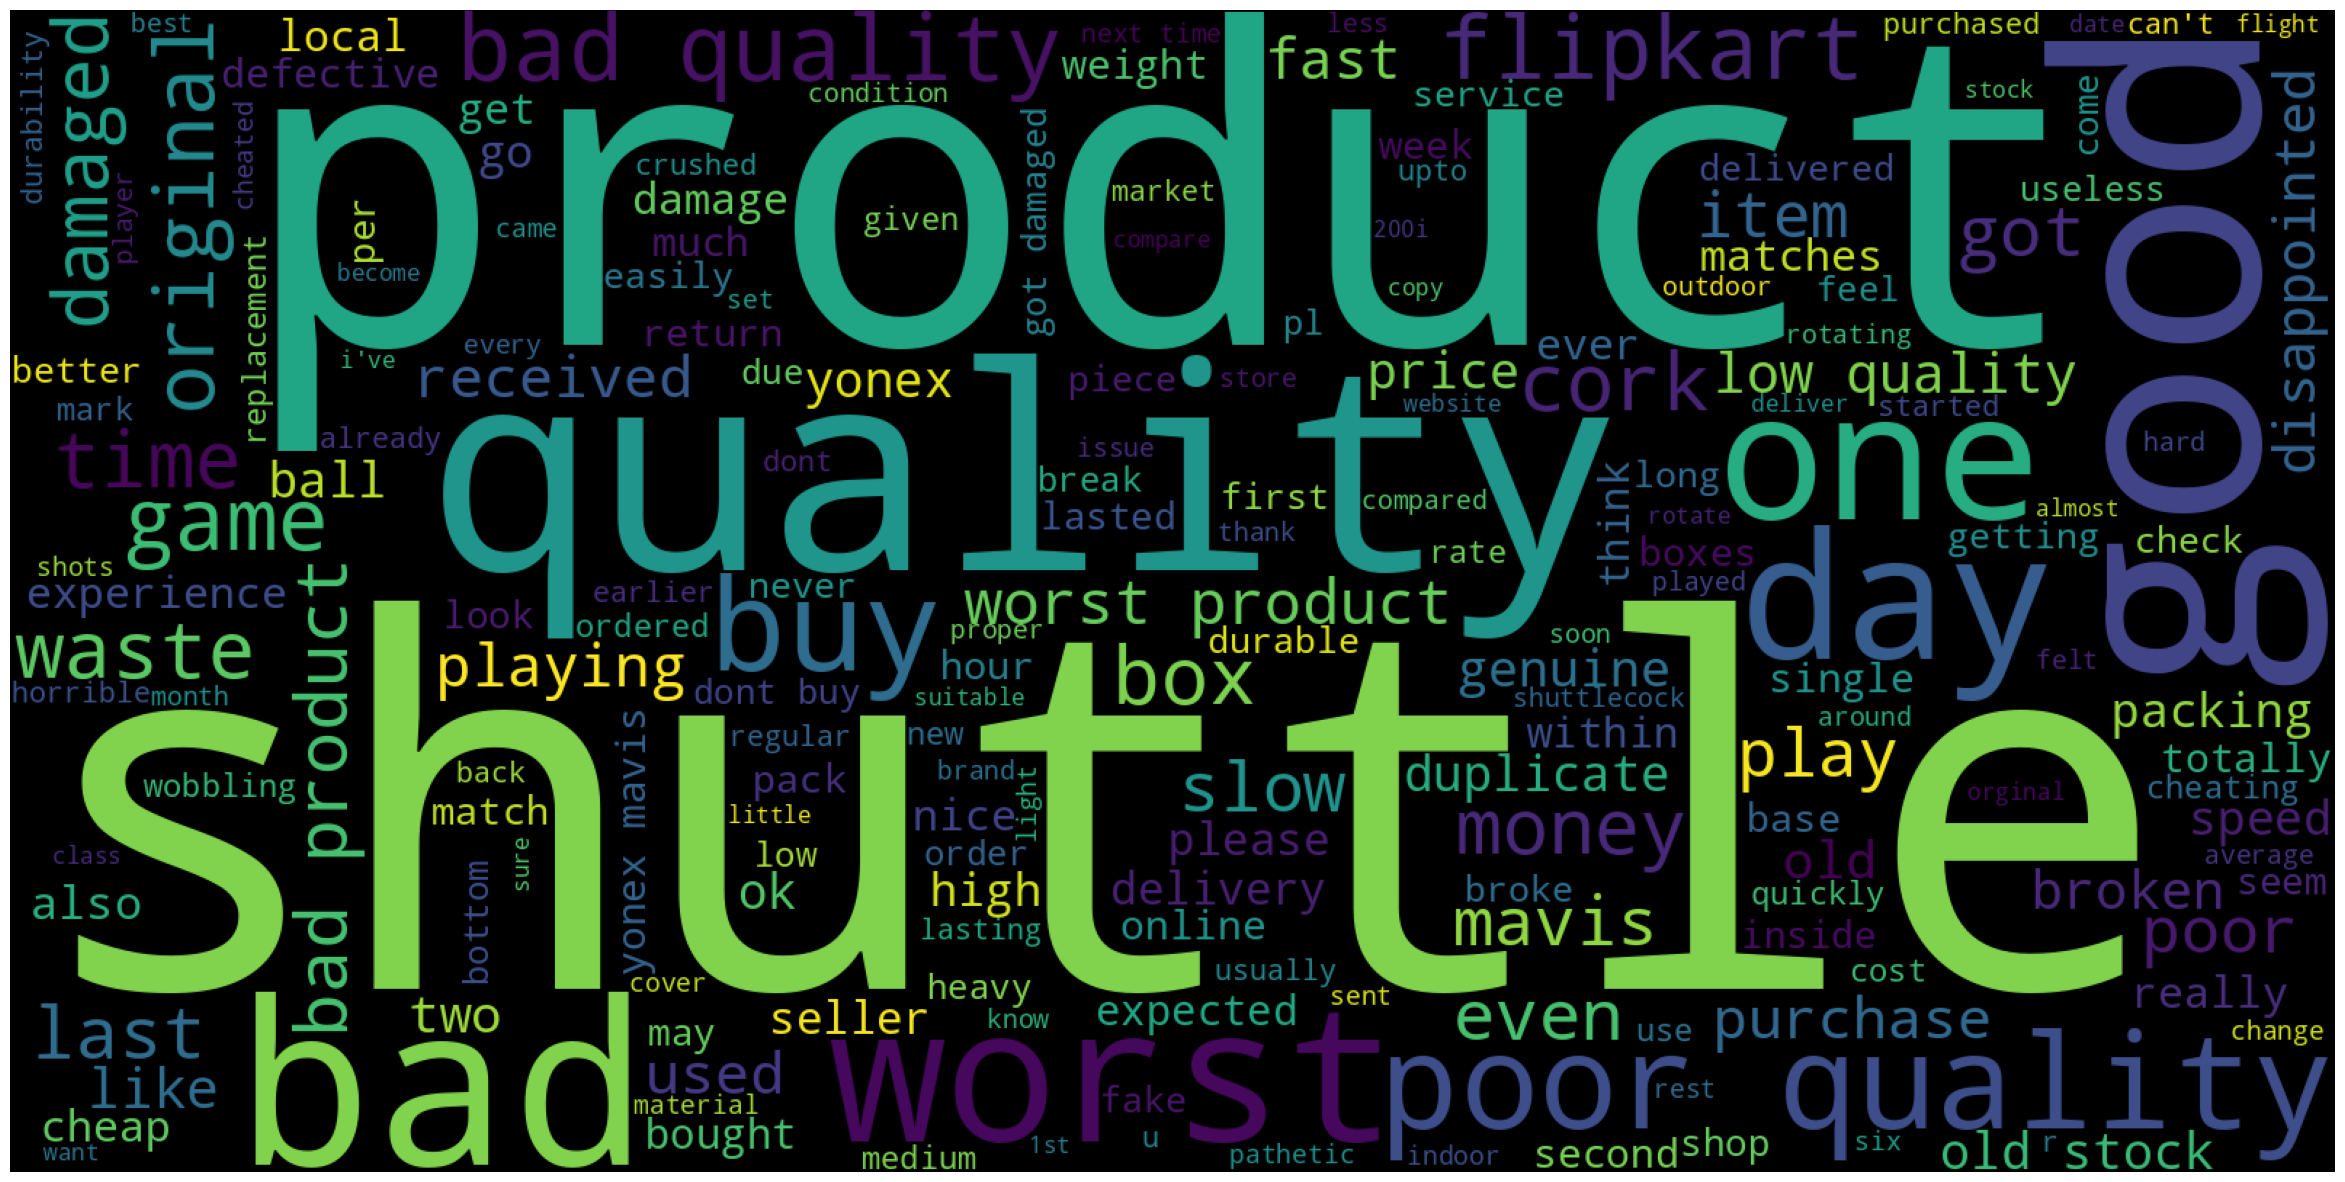

In [25]:
df_negative = df[df["Label"] == "Negative"]

words = " ".join(df_negative["Review text"]).lower()

clean_words = " ".join([word for word in words.split() if word not in word_list])
positive_wordcloud = WordCloud(stopwords=stopwords.words("english"),
                      background_color='black',
                      width=1600,
                      height=800
                     ).generate(clean_words)
plt.figure(1,figsize=(30,20))
plt.imshow(positive_wordcloud)
plt.axis('off')
plt.show()

# Train and Test Split

In [26]:
X = df[["Review text"]]
y = df["Label"]

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5578, 1)
(5578,)
(1860, 1)
(1860,)


# Text Preprocessing

In [28]:
def preprocess(raw_text, flag = None):
  text = re.sub("[^a-zA-Z]", " ", raw_text)

  text = text.lower()

  words = word_tokenize(text)

  if flag == "stem":
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words if word not in stopwords.words("english")]
  else:
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words("english")]
  preprocessed_text = " ".join(words)
  preprocessed_text_length = len(words)

  return pd.Series([preprocessed_text, preprocessed_text_length])

In [29]:
df[["Review text"]]

,Review text
0,"Nice product, good quality, but price is now r..."
1,They didn't supplied Yonex Mavis 350. Outside ...
2,Worst product. Damaged shuttlecocks packed in ...
5,Good quality product. Delivered on time.
6,BEST PURCHASE It is a good quality and is more...
...,...
8495,Thanks to the delivery boy ... Service is alwa...
8496,Over priced even after 50% discount price is m...
8497,Too much priced. It was getting me for Rs. 640...
8499,Hii flipkart customers care..why your delivery...


# Cleaning Training Data

In [30]:
X_train_stem = X_train["Review text"].apply(lambda x: preprocess(x, "stem"))

In [31]:
X_train_stem.columns = ["clean_text_stem", "text_length_stem"]
X_train_stem.head()

,clean_text_stem,text_length_stem
7364,good,1
4990,old stock manufactur year back month,6
3619,good,1
6143,guinin product,2
2830,damag quickli play hardli match per shuttl,7


In [32]:
X_train_lemmatizer = X_train["Review text"].apply(lambda x: preprocess(x))
X_train_lemmatizer.columns = ["clean_text_lemma", "text_length_lemma"]
X_train_lemmatizer.head()

,clean_text_lemma,text_length_lemma
7364,good,1
4990,old stock manufactured year back month,6
3619,good,1
6143,guinine product,2
2830,damaged quickly played hardly match per shuttle,7


In [33]:
X_train = pd.concat([X_train, X_train_stem, X_train_lemmatizer], axis = 1)

In [34]:
X_train.head()

,Review text,clean_text_stem,text_length_stem,clean_text_lemma,text_length_lemma
7364,good,good,1,good,1
4990,old stock. manufactured a year back(12 months),old stock manufactur year back month,6,old stock manufactured year back month,6
3619,Good,good,1,good,1
6143,Guinine product,guinin product,2,guinine product,2
2830,Damaged very quickly.Played hardly for 02 matc...,damag quickli play hardli match per shuttl,7,damaged quickly played hardly match per shuttle,7


# Cleaning test data

In [35]:
X_test_stem = X_test["Review text"].apply(lambda x: preprocess(x, "stem"))

X_test_stem.columns = ["clean_text_stem", "text_length_stem"]


X_test_lemmatizer = X_test["Review text"].apply(lambda x: preprocess(x))
X_test_lemmatizer.columns = ["clean_text_lemma", "text_length_lemma"]


X_test = pd.concat([X_test, X_test_stem, X_test_lemmatizer], axis = 1)

X_test.head()

,Review text,clean_text_stem,text_length_stem,clean_text_lemma,text_length_lemma
1140,Good,good,1,good,1
5765,Nice,nice,1,nice,1
2625,Bad quality,bad qualiti,2,bad quality,2
1468,Product is good.,product good,2,product good,2
2446,Nice product.,nice product,2,nice product,2


# Bag of Word Representation

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

CV = CountVectorizer()

X_train_bow = CV.fit_transform(X_train["clean_text_lemma"])


print(X_train_bow.shape)

(5578, 1921)


In [37]:
X_test_bow = CV.transform(X_test["clean_text_lemma"])

print(X_test_bow.shape)

(1860, 1921)


# TF-IDF Representation

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

TV = TfidfVectorizer()

X_train_tf = TV.fit_transform(X_train["clean_text_lemma"])

print(X_train_tf.shape)

(5578, 1921)


In [39]:
X_test_tf = TV.transform(X_test["clean_text_lemma"])

print(X_test_tf.shape)

(1860, 1921)


# Word2Vec Representation

In [40]:
!pip install --upgrade -q gensim

In [41]:
import gensim

print(gensim.__version__)

4.3.2


In [42]:
from gensim.models import Word2Vec

X_train['tokenised_sentences'] = X_train.clean_text_stem.apply(lambda sent : sent.split())

X_train.head()

,Review text,clean_text_stem,text_length_stem,clean_text_lemma,text_length_lemma,tokenised_sentences
7364,good,good,1,good,1,[good]
4990,old stock. manufactured a year back(12 months),old stock manufactur year back month,6,old stock manufactured year back month,6,"[old, stock, manufactur, year, back, month]"
3619,Good,good,1,good,1,[good]
6143,Guinine product,guinin product,2,guinine product,2,"[guinin, product]"
2830,Damaged very quickly.Played hardly for 02 matc...,damag quickli play hardli match per shuttl,7,damaged quickly played hardly match per shuttle,7,"[damag, quickli, play, hardli, match, per, shu..."


In [43]:
list(X_train.tokenised_sentences)

[['good'],
 ['old', 'stock', 'manufactur', 'year', 'back', 'month'],
 ['good'],
 ['guinin', 'product'],
 ['damag', 'quickli', 'play', 'hardli', 'match', 'per', 'shuttl'],
 ['good', 'qualiti'],
 ['good'],
 ['yonex',
  'r',
  'use',
  'sinc',
  'yr',
  'good',
  'qualiti',
  'better',
  'price',
  'open',
  'market',
  'shop',
  'better',
  'select',
  'slow',
  'play',
  'outdoor',
  'shuttl'],
 ['good'],
 ['nice', 'shuttl'],
 ['fast', 'deleveri', 'item', 'qualiti', 'good'],
 ['good', 'one', 'receiv', 'origin', 'product', 'thank', 'flipkart'],
 ['qualiti', 'shuttl', 'good'],
 ['play', 'two', 'day', 'shuttl', 'start', 'broke'],
 ['nice', 'product'],
 ['qualiti', 'good'],
 ['valu', 'money'],
 ['good', 'qualiti', 'shuttl'],
 ['poor', 'qualiti', 'shuttl'],
 ['damag', 'item'],
 ['cork', 'good'],
 ['good', 'qualiti', 'time', 'durabl'],
 ['good', 'product'],
 ['u', 'buy', 'good', 'product'],
 ['got',
  'product',
  'earlier',
  'expect',
  'rs',
  'th',
  'april',
  'sale',
  'box',
  'properl

In [44]:
# train model

model = Word2Vec(list(X_train.tokenised_sentences), vector_size=300, min_count=1)

In [45]:
print(model)

Word2Vec<vocab=1673, vector_size=300, alpha=0.025>


In [46]:
print(model.wv.__getitem__(model.wv.index_to_key).shape)

(1673, 300)


In [47]:
def document_vector(doc, keyed_vectors):
    """Remove out-of-vocabulary words. Create document vectors by averaging word vectors."""
    vocab_tokens = [word for word in doc if word in keyed_vectors.index_to_key]
    if not vocab_tokens:
        return np.zeros(keyed_vectors.vector_size)  # Handle empty vocab_tokens
    return np.mean(keyed_vectors.__getitem__(vocab_tokens), axis=0)

In [48]:
X_train['doc_vector_w2v'] = X_train.tokenised_sentences.apply(lambda x : document_vector(x, model.wv))

X_train.head()

,Review text,clean_text_stem,text_length_stem,clean_text_lemma,text_length_lemma,tokenised_sentences,doc_vector_w2v
7364,good,good,1,good,1,[good],"[-0.026119381, 0.08436273, 0.008292558, 0.0379..."
4990,old stock. manufactured a year back(12 months),old stock manufactur year back month,6,old stock manufactured year back month,6,"[old, stock, manufactur, year, back, month]","[-0.022307513, 0.07063373, 0.006978338, 0.0297..."
3619,Good,good,1,good,1,[good],"[-0.026119381, 0.08436273, 0.008292558, 0.0379..."
6143,Guinine product,guinin product,2,guinine product,2,"[guinin, product]","[-0.019461902, 0.057149004, 0.0036950102, 0.02..."
2830,Damaged very quickly.Played hardly for 02 matc...,damag quickli play hardli match per shuttl,7,damaged quickly played hardly match per shuttle,7,"[damag, quickli, play, hardli, match, per, shu...","[-0.033438347, 0.109210804, 0.008821824, 0.045..."


In [49]:
X_train_w2v = list(X_train.doc_vector_w2v)

In [50]:
X_test['tokenised_sentences'] = X_test.clean_text_lemma.apply(lambda sent : sent.split())

X_test.head()

,Review text,clean_text_stem,text_length_stem,clean_text_lemma,text_length_lemma,tokenised_sentences
1140,Good,good,1,good,1,[good]
5765,Nice,nice,1,nice,1,[nice]
2625,Bad quality,bad qualiti,2,bad quality,2,"[bad, quality]"
1468,Product is good.,product good,2,product good,2,"[product, good]"
2446,Nice product.,nice product,2,nice product,2,"[nice, product]"


In [51]:
X_test['doc_vector_w2v'] = X_test['tokenised_sentences'].apply(lambda x: document_vector(x, model.wv))
X_test.head()

,Review text,clean_text_stem,text_length_stem,clean_text_lemma,text_length_lemma,tokenised_sentences,doc_vector_w2v
1140,Good,good,1,good,1,[good],"[-0.026119381, 0.08436273, 0.008292558, 0.0379..."
5765,Nice,nice,1,nice,1,[nice],"[-0.015087102, 0.05707855, 0.004157435, 0.0249..."
2625,Bad quality,bad qualiti,2,bad quality,2,"[bad, quality]","[-0.026619572, 0.090931036, 0.0041153342, 0.03..."
1468,Product is good.,product good,2,product good,2,"[product, good]","[-0.03173717, 0.10066755, 0.0084928665, 0.0422..."
2446,Nice product.,nice product,2,nice product,2,"[nice, product]","[-0.026221033, 0.08702546, 0.0064253053, 0.035..."


In [52]:
X_test_w2v = list(X_test.doc_vector_w2v)

# Development of model

## Bow

### Logistic Regression BoW

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

LR_bow = LogisticRegression()

LR_bow.fit(X_train_bow, y_train)

y_test_pred = LR_bow.predict(X_test_bow)

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.9268817204301075
              precision    recall  f1-score   support

    Negative       0.83      0.58      0.68       253
    Positive       0.94      0.98      0.96      1607

    accuracy                           0.93      1860
   macro avg       0.89      0.78      0.82      1860
weighted avg       0.92      0.93      0.92      1860



Multinomial Logistic Regression

### Decision Tree BoW

In [54]:
from sklearn.tree import DecisionTreeClassifier

DTC_bow = DecisionTreeClassifier()

DTC_bow.fit(X_train_bow, y_train)

y_test_pred = DTC_bow.predict(X_test_bow)

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.9016129032258065
              precision    recall  f1-score   support

    Negative       0.64      0.63      0.64       253
    Positive       0.94      0.94      0.94      1607

    accuracy                           0.90      1860
   macro avg       0.79      0.79      0.79      1860
weighted avg       0.90      0.90      0.90      1860



### RandomForestClassiffier BoW

In [55]:
from sklearn.ensemble import RandomForestClassifier

RFC_bow = RandomForestClassifier()

RFC_bow.fit(X_train_bow, y_train)

y_test_pred = RFC_bow.predict(X_test_bow)

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.9193548387096774
              precision    recall  f1-score   support

    Negative       0.76      0.60      0.67       253
    Positive       0.94      0.97      0.95      1607

    accuracy                           0.92      1860
   macro avg       0.85      0.78      0.81      1860
weighted avg       0.91      0.92      0.92      1860



### KneighborsClassifier Bow

In [56]:
from sklearn.neighbors import KNeighborsClassifier

KNC_bow = KNeighborsClassifier()

KNC_bow.fit(X_train_bow, y_train)

y_test_pred = KNC_bow.predict(X_test_bow)

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.9139784946236559
              precision    recall  f1-score   support

    Negative       0.84      0.45      0.59       253
    Positive       0.92      0.99      0.95      1607

    accuracy                           0.91      1860
   macro avg       0.88      0.72      0.77      1860
weighted avg       0.91      0.91      0.90      1860



### MultinomialNB Bow

In [57]:
from sklearn.naive_bayes import MultinomialNB

MNB_bow = MultinomialNB()

MNB_bow.fit(X_train_bow, y_train)

y_test_pred = MNB_bow.predict(X_test_bow)

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.9198924731182796
              precision    recall  f1-score   support

    Negative       0.78      0.57      0.66       253
    Positive       0.94      0.97      0.95      1607

    accuracy                           0.92      1860
   macro avg       0.86      0.77      0.81      1860
weighted avg       0.91      0.92      0.91      1860



## TF-IDF

### Logistic Regression TF-IDF

In [58]:
LR_TFIDF = LogisticRegression()

LR_TFIDF.fit(X_train_tf, y_train)

y_test_pred = LR_TFIDF.predict(X_test_tf)

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.9225806451612903
              precision    recall  f1-score   support

    Negative       0.88      0.50      0.64       253
    Positive       0.93      0.99      0.96      1607

    accuracy                           0.92      1860
   macro avg       0.90      0.75      0.80      1860
weighted avg       0.92      0.92      0.91      1860



### Decision Tree TF-IDF

In [59]:
DTC_TFIDF = DecisionTreeClassifier()

DTC_TFIDF.fit(X_train_tf, y_train)

y_test_pred = DTC_TFIDF.predict(X_test_tf)

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.9016129032258065
              precision    recall  f1-score   support

    Negative       0.66      0.58      0.62       253
    Positive       0.94      0.95      0.94      1607

    accuracy                           0.90      1860
   macro avg       0.80      0.77      0.78      1860
weighted avg       0.90      0.90      0.90      1860



### Random Forest Classifier TF-IDF

In [60]:
RFC_TFIDF = RandomForestClassifier()

RFC_TFIDF.fit(X_train_tf, y_train)

y_test_pred = RFC_TFIDF.predict(X_test_tf)

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.917741935483871
              precision    recall  f1-score   support

    Negative       0.81      0.52      0.63       253
    Positive       0.93      0.98      0.95      1607

    accuracy                           0.92      1860
   macro avg       0.87      0.75      0.79      1860
weighted avg       0.91      0.92      0.91      1860



### Kneighbors Classifier TF-IDF

In [61]:
KNC_TFIDF = KNeighborsClassifier()

KNC_TFIDF.fit(X_train_tf, y_train)

y_test_pred = KNC_TFIDF.predict(X_test_tf)

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.8946236559139785
              precision    recall  f1-score   support

    Negative       0.78      0.31      0.45       253
    Positive       0.90      0.99      0.94      1607

    accuracy                           0.89      1860
   macro avg       0.84      0.65      0.69      1860
weighted avg       0.88      0.89      0.87      1860



### MultinomialNB TF-IDF

In [62]:
MNB_TFIDF = MultinomialNB()

MNB_TFIDF.fit(X_train_tf, y_train)

y_test_pred = MNB_TFIDF.predict(X_test_tf)

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.8989247311827957
              precision    recall  f1-score   support

    Negative       0.87      0.30      0.45       253
    Positive       0.90      0.99      0.94      1607

    accuracy                           0.90      1860
   macro avg       0.89      0.65      0.70      1860
weighted avg       0.90      0.90      0.88      1860



## Word2Vec

### Logistic Regression Word2Vec

In [63]:
LR_w2v = LogisticRegression()

LR_w2v.fit(X_train_w2v, y_train)

y_test_pred = LR_w2v.predict(X_test_w2v)

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.863978494623656
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       253
    Positive       0.86      1.00      0.93      1607

    accuracy                           0.86      1860
   macro avg       0.43      0.50      0.46      1860
weighted avg       0.75      0.86      0.80      1860



### Decision Tree Word2Vec

In [64]:
DTC_w2v = DecisionTreeClassifier()

DTC_w2v.fit(X_train_w2v, y_train)

y_test_pred = DTC_w2v.predict(X_test_w2v)

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.8580645161290322
              precision    recall  f1-score   support

    Negative       0.47      0.38      0.42       253
    Positive       0.91      0.93      0.92      1607

    accuracy                           0.86      1860
   macro avg       0.69      0.66      0.67      1860
weighted avg       0.85      0.86      0.85      1860



### Random Forest Classifier Word2Vec

In [65]:
RFC_w2v = RandomForestClassifier()

RFC_w2v.fit(X_train_w2v, y_train)

y_test_pred = RFC_w2v.predict(X_test_w2v)

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.8795698924731182
              precision    recall  f1-score   support

    Negative       0.71      0.19      0.30       253
    Positive       0.89      0.99      0.93      1607

    accuracy                           0.88      1860
   macro avg       0.80      0.59      0.62      1860
weighted avg       0.86      0.88      0.85      1860



### Kneighbors Classifier Word2Vec

In [66]:
KNC_w2v = KNeighborsClassifier()

KNC_w2v.fit(X_train_w2v, y_train)

y_test_pred = KNC_w2v.predict(X_test_w2v)

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.8768817204301075
              precision    recall  f1-score   support

    Negative       0.60      0.28      0.38       253
    Positive       0.90      0.97      0.93      1607

    accuracy                           0.88      1860
   macro avg       0.75      0.63      0.66      1860
weighted avg       0.86      0.88      0.86      1860



In [86]:
filename = "MNB_bow_model.pkl"
jb.dump(MNB_bow, filename)

['MNB_bow_model.pkl']

In [87]:
model_MNB_bow = jb.load("MNB_bow_model.pkl")

In [88]:
y_test_pred = model_MNB_bow.predict(X_test_bow)

print(accuracy_score(y_test,y_test_pred))

0.9198924731182796


In [89]:
filename = "CV_vectorizer.pkl"
jb.dump(CV, filename)

['CV_vectorizer.pkl']

In [90]:
with open('MNB_bow_model.pkl', 'rb') as model:
     model = jb.load(model)

In [91]:
with open('CV_vectorizer.pkl', 'rb') as TF_vect:
     vectorizer = jb.load(TF_vect)

In [94]:
df["Review text"][0]

'Nice product, good quality, but price is now rising which is a bad sign. 800-850 was an affordable price, especially when we play everyday. So kindly help us out in terms of the price. Thank You.'

In [95]:
user_review = "Nice product, good quality, but price is now rising which is a bad sign. 800-850 was an affordable price, especially when we play everyday. So kindly help us out in terms of the price. Thank You."
text = vectorizer.transform([user_review])
pred = model.predict(text)[0]

In [96]:
pred

'Positive'